In [15]:
using DataFrames, CSV
using StatsBase, Statistics
using LinearAlgebra

#Credit to Prof. Darin England and the University of Minnesota - Twin Cities for the idea and base imp of this project.
US = CSV.read("USArrests.csv", DataFrame)
USm = Matrix(US[:, 2:5]) 
USsc = standardize(ZScoreTransform, USm, dims=1) # Scale each attribute to have mean 0 and std dev 1

# Function to compute the squared Euclidean distance between two vectors x and y.
function distance(x, y)
    return sqrt(sum((x .- y).^2))
end


# Function to compute the centroid of a cluster.
# X is a matrix that contains the cluster,
# with rows as observations and (numeric) columns as attributes.
function centroid(X)
    return sum(X, dims=1) / size(X, 1)
end

# A single iteration of K-means
function kmeans1(X, k)
    (m, n) = size(X)
    if k > m
        error("number of clusters ", k, " > number of observations ", m)
    end

    clusters0 = rand(1:k, m)  # random initial assignment
    clusters = zeros(Int8, m) # will hold the cluster assignments

    ii = 0
    while true
        # Compute the cluster centroids
        c = zeros(k, n)
        for i in 1:k
            c[i, :] = centroid(X[findall(x -> x == i, clusters0), :])
        end

        # Assign each observation to the nearest centroid
        for i in 1:m
            clusters[i] = 1  # initially assign observation to cluster 1
            best = distance(X[i, :], c[1, :])
            for j in 2:k
                candidate = distance(X[i, :], c[j, :])
                if candidate < best  # assign to cluster j if closer
                    best = candidate
                    clusters[i] = j
                end
            end
        end
        if clusters == clusters0
            break
        end
        clusters0 = clusters
        ii += 1
    end
    ncl = length(countmap(clusters))
    if ncl != k
        @warn "clustering solution contains "*string(ncl)*" < "*string(k)*" clusters."
    end
    return clusters
end

# A function to compute the value of the K-means objective
# function, the sum of the within-cluster distances.
# X is the matrix of observations.
# k is the number of clusters.
# cl is the clustering solution.


function objective(X, k, cl)
    n = countmap(cl)
    obj = 0.0
    for i in keys(n)
        clusteri = X[ findall(x->x==i, cl), : ]
        μ = centroid(clusteri)
        for j in 1:n[i]
            obj += distance(clusteri[j,:], μ)
        end
    end
    return obj
end



# Driver function for K-means.
# X is the (scaled) matrix of observations.
# k is the number of clusters.
# niter is the number of times to run the K-means algorithm.
# The best of the niter candidate solutions is returned.
function kmeans(X, k; niter=50)
    sol = nothing
    search_obj = Inf

    for _ in 1:niter
        cl = kmeans1(X, k)
        obj = objective(X, k, cl)
        if obj < search_obj
            sol = cl
            search_obj = obj
        end
    end

    return sol
end

cl = kmeans(USsc, 4);    # call kmeans driver function
obj_val = objective(USsc, 4, cl)   # the objective function of the best solution found
cldict = countmap(cl)    # use countmap() to see the number of obs in each cluster


vars = ["murder", "assault", "urbanpop", "rape"]

#print the mean attributes for each cluster
for j in 1:4
    for i in keys(cldict)
        c = centroid(USm[ findall(x->x==1, cl), :])
        println("mean of cluster ", i, " for", vars[j], " =", round(c[j], digits=2))
    end
end



println("Clustering solution: ", cl)
println("Objective function value: ", obj_val)
println("Number of observations in each cluster: ", cldict)


mean of cluster 4 formurder =7.08
mean of cluster 2 formurder =7.08
mean of cluster 3 formurder =7.08
mean of cluster 1 formurder =7.08
mean of cluster 4 forassault =185.2
mean of cluster 2 forassault =185.2
mean of cluster 3 forassault =185.2
mean of cluster 1 forassault =185.2
mean of cluster 4 forurbanpop =63.8
mean of cluster 2 forurbanpop =63.8
mean of cluster 3 forurbanpop =63.8
mean of cluster 1 forurbanpop =63.8
mean of cluster 4 forrape =21.68
mean of cluster 2 forrape =21.68
mean of cluster 3 forrape =21.68
mean of cluster 1 forrape =21.68
Clustering solution: Int8[4, 4, 4, 1, 4, 4, 2, 1, 4, 4, 3, 2, 4, 3, 2, 3, 3, 4, 2, 4, 3, 4, 2, 4, 1, 2, 2, 4, 2, 3, 4, 4, 4, 2, 3, 3, 1, 3, 3, 4, 2, 4, 4, 3, 2, 3, 3, 2, 2, 1]
Objective function value: 140.22440827645374
Number of observations in each cluster: Dict{Int8, Int64}(4 => 19, 2 => 13, 3 => 13, 1 => 5)


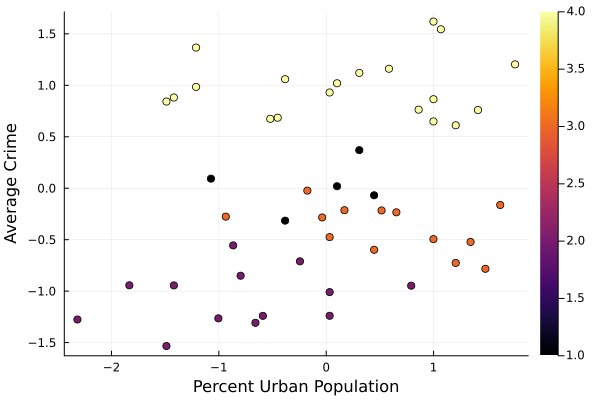

In [16]:
using Plots

(m,n) = size(USsc)
avgcrime = zeros(m)
for i in 1:m
    avgcrime[i] = sum(USsc[i, [1,2,4]])/3
end

scatter(USsc[:,3], avgcrime, zcolor=cl, lab="", xlabel = "Percent Urban Population", ylabel = "Average Crime")


1. Distance function. This is just euclidean distance that will be used in the centroid function.
2. centroid. I implemented this using the equation from the lecture notes. Essenatially, given a cluster C_i, its centroid is u_i(c_i) = (1/|c_i|) * sum(x), where x is the elements of c_i.
3. objective function. The objective function for kmeans is also implemented from lecture notes. Essentially, min( sum to k from i=1( sum of xεc_i (of the euclidean distance between x and u_i(c_i) squared, or ||x-u_i(c_i)||^2. While I had the algorithm and function already, it was difficult to actually implement in code.
4. The driver function for kmeans. This basically just took the provided kmeans1 function and found the best one out of 50 attempts compared to the obj function.
5. Above is also the clustering of average crimes per percent of urban population, captured in a scatter graph